## Initial Cleaning Steps

I read this data in as string because it was difficult to do so otherwise

In [ ]:
# import data csv
import pandas as pd
df = pd.read_csv("C:/Users/Farhan/Documents/data/lending-club-loan-data/loan.csv", delimiter = ",",index_col=False, dtype = "str")

In [41]:
#check shape to ensure data transferred as expected
df.shape

(2260668, 145)

In [42]:
# check dependent variable counts
print(df["loan_status"].value_counts())

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64


In [43]:
# remove unwanted categories from dependent variable
df = df[df.loan_status != "Current"]
df = df[df.loan_status != "Late (31-120 days)"]
df = df[df.loan_status != "Late (16-30 days)"]
df = df[df.loan_status != "In Grace Period"]
df = df[df.loan_status != "Default"]
df = df[df.loan_status != "Does not meet the credit policy. Status:Fully Paid"]
df = df[df.loan_status != "Does not meet the credit policy. Status:Charged Off"]


In [44]:
# remove any columns that have a huge no-value count 
df.dropna(thresh = 1500000, axis = 1, inplace = True)

In [45]:
# now remove all rows with any no-value cells in them
df = df.dropna(axis = 0, how = 'any')

In [ ]:
#export to csv
df.to_csv('C:/Users/Farhan/Documents/Capstone/Data_no_NAN.csv')

Exported this to CSV as loading the full data again and again was becoming cumbersome. After this, I only work with the new CSV.

## Secondary Steps

In [1]:
# Read in the cleaned csv
import pandas as pd
final = pd.read_csv('C:/Users/Farhan/Documents/Capstone/Data_no_NAN.csv')

In [2]:
# check shape
final.shape

(955257, 88)

I removed certain columns from the analysis because this was information a lender would not have while giving a loan and so it was giving the model very high predictive powers.

In [162]:
# Remove columns that represent information not necessary or not information available to lender while giving the loan
final = final.drop(['debt_settlement_flag','out_prncp','last_pymnt_d','last_pymnt_amnt','out_prncp_inv','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','total_rec_prncp','total_rev_hi_lim','total_rec_int'],axis = 1)

In [29]:
# set the data up to do the train-test split to calculate mutual info scores
from sklearn.model_selection import train_test_split


df_y = final['loan_status']
df_x = final.drop(['loan_status'],axis = 1)

X = df_x
y = df_y

In [124]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y)

C:\Users\Farhan\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


[]

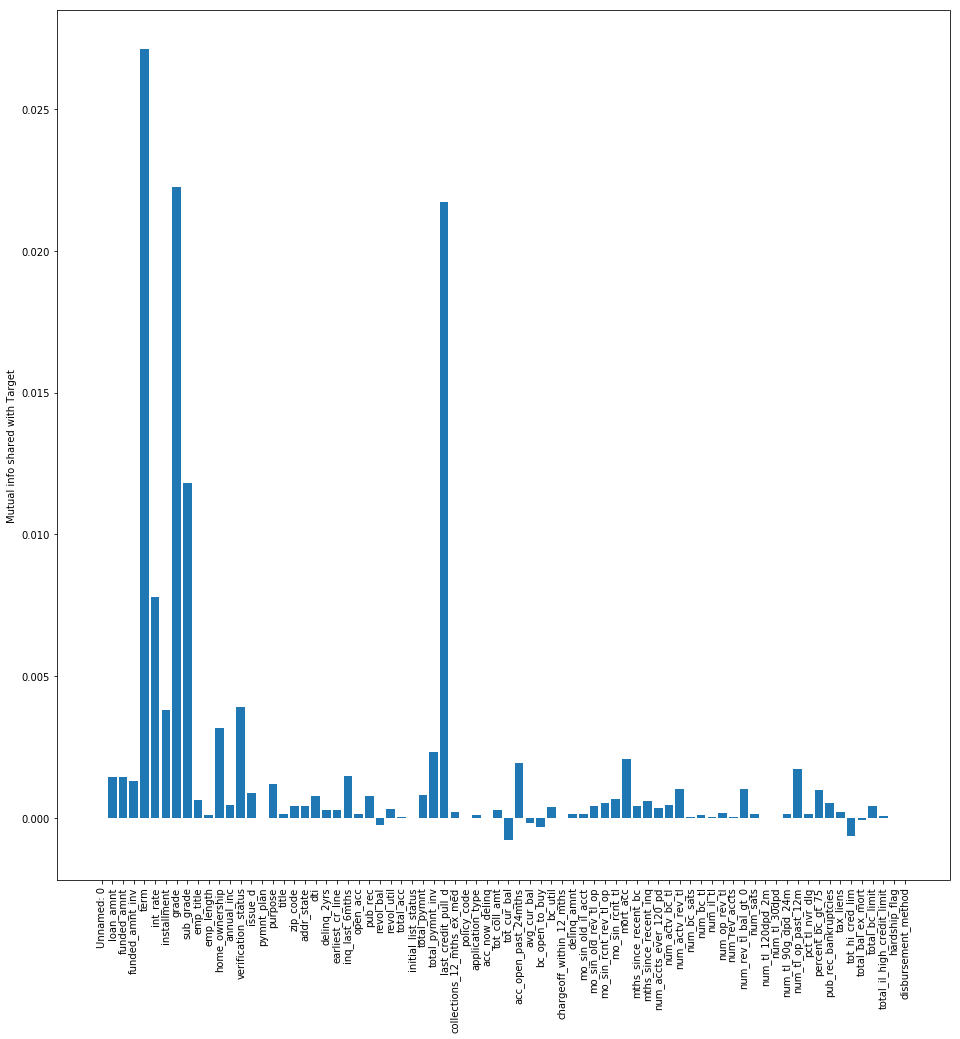

In [116]:
# take a look at the mutual info scores to select which features will be part of the model
from sklearn.metrics import adjusted_mutual_info_score
import matplotlib.pyplot as plt

mutual_info_scores = []

for feature in X_train.columns:
    # Calculate the mutual info score
    m_info = adjusted_mutual_info_score(X_train[feature], y_train)
    # Append it to our list
    mutual_info_scores.append(m_info)

plt.figure(figsize = (16,16))
plt.bar(X_train.columns, mutual_info_scores)
plt.ylabel('Mutual info shared with Target')
plt.xticks(rotation=90)
plt.plot()

In [86]:
# Select the columns with highest mutual information scores
col_list =['loan_status','annual_inc','loan_amnt','term','pub_rec','chargeoff_within_12_mths', 'int_rate', 'installment','grade', 'home_ownership', 'verification_status','purpose','dti','inq_last_6mths','acc_open_past_24mths','mort_acc','num_actv_rev_tl','num_rev_tl_bal_gt_0','num_tl_op_past_12m','percent_bc_gt_75','tot_hi_cred_lim','total_il_high_credit_limit']

In [87]:
# include only the columns selected
final = final[col_list]
final = final[final.purpose != 'educational']

Since assigning positive label to one class was still leading to confusion, I decided to convert the dependent variable to a binary 0 and 1 for the two classes.

In [88]:
# convert y variable to 0/1 binary
final['status'] = np.where(final['loan_status']=='Charged Off',1,0)

In [89]:
# check final shape of data
final.shape

(955256, 23)

In [90]:
# re-do after changes
from sklearn.model_selection import train_test_split


df_y = final['status']
df_x = final.drop(['loan_status','status'],axis = 1)

X = df_x
y = df_y

In [91]:
# do the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y)

In [92]:
# One-hot encode categorical variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)


In [96]:
# Take a look at the data
X_test.head()

,annual_inc,loan_amnt,pub_rec,chargeoff_within_12_mths,int_rate,installment,dti,inq_last_6mths,acc_open_past_24mths,mort_acc,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
95536,112000.0,30000,0,0,25.44,888.30,23.63,1,13,2,...,0,0,0,0,0,0,0,0,0,0
884823,63900.0,18200,0,0,10.99,595.76,23.12,0,1,3,...,0,0,0,0,0,0,0,0,0,0
467490,82000.0,10000,0,0,7.89,312.86,5.80,0,3,1,...,0,0,0,0,0,0,0,0,0,0
573949,40000.0,10000,0,0,13.59,339.79,13.11,0,6,2,...,0,0,0,0,0,0,0,0,0,0
829016,91000.0,12000,0,0,12.49,401.39,16.48,1,1,1,...,1,0,0,0,0,0,0,0,0,0


## Let's now scale data

In [93]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
# Instantiate
scaler.fit(X_train)
# Transform the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

For evaluation purposes, we will not look at just accuracy because data imbalance means the data is already almost 80% of one class. We will try to achieve the highest possible recall so predicting as many of the charged-off class with the highest f1 score.

## Logistic Model

C = 1e-08
Accuracy = 0.6175821702525235
Recall = 0.7045263600084016
Precision = 0.30272502157567277
f1 score = 0.4234846661590237
Confusion matrix:
 [[182312 123615]
 [ 22508  53668]]


C = 1e-07
Accuracy = 0.6175219770585418
Recall = 0.704736399915984
Precision = 0.3027213569567718
f1 score = 0.4235190167012473
Confusion matrix:
 [[182273 123654]
 [ 22492  53684]]


C = 1e-06
Accuracy = 0.6186499451718516
Recall = 0.705419029615627
Precision = 0.3035743541361836
f1 score = 0.42447677013432755
Confusion matrix:
 [[182652 123275]
 [ 22440  53736]]


C = 1e-05
Accuracy = 0.6295056568516866
Recall = 0.6923571728628439
Precision = 0.3086561364288097
f1 score = 0.42696792943909917
Confusion matrix:
 [[187795 118132]
 [ 23435  52741]]


C = 0.0001
Accuracy = 0.6409973227114155
Recall = 0.6752914303717706
Precision = 0.31389048217619997
f1 score = 0.4285714285714286
Confusion matrix:
 [[193486 112441]
 [ 24735  51441]]


C = 0.001
Accuracy = 0.6434626265692758
Recall = 0.670933102289435
Preci

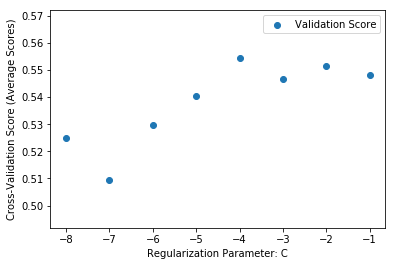

In [102]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Lets plot out different parameters with 5-fold cross validation
accuracy_score_train = []
accuracy_score_test = []
validation_score_list = []
sample_range = [.00000001,.0000001,.000001,.00001,.0001,0.001,0.01,0.1]

for c in sample_range:
    # Instantiate
    LR_model = LogisticRegression(C=c, class_weight = 'balanced')
    validation_score = np.mean(cross_val_score(LR_model, X_train, y_train, cv = 5))
    validation_score_list.append(validation_score)
    
    # Fit
    LR_model.fit(X_train_scaled, y_train)
    
    # predict
    pred_train = LR_model.predict(X_train_scaled)
    pred_test = LR_model.predict(X_test_scaled)

    #Score
    Train_score = LR_model.score(X_train_scaled, y_train)
    Accuracy = LR_model.score(X_test_scaled, y_test)
    recall = recall_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test)
    f1score = f1_score(y_test, pred_test)
    cmat = confusion_matrix(y_test, pred_test)
    
    
    print('C =', c)
    print('Accuracy =', Accuracy)
    print('Recall =', recall)
    print('Precision =', precision)
    print('f1 score =', f1score)
    print('Confusion matrix:\n', cmat)
    print('\n')
    

%matplotlib inline
plt.scatter(np.log10(sample_range), validation_score_list,label="Validation Score",marker='o')
plt.legend()
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross-Validation Score (Average Scores)')
plt.show();

    
    

## Let's try Decision Trees and see if they give better f1 scores

In [46]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
    
for i in np.arange(1,50,10):
    # Instantiate
    my_tree = DecisionTreeClassifier(max_depth = i, class_weight = 'balanced')

    # Fit
    my_tree.fit(X_train_scaled, y_train)

    # predict
    pred_train = my_tree.predict(X_train_scaled)
    pred_test = my_tree.predict(X_test_scaled)

    # Score
    Train_score = my_tree.score(X_train_scaled, y_train)
    Accuracy = my_tree.score(X_test_scaled, y_test)
    recall = recall_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test)
    f1score = f1_score(y_test, pred_test)
    cmat = confusion_matrix(y_test, pred_test)
    
    
    print('C =', i)
    print('Accuracy =', Accuracy)
    print('Recall =', recall)
    print('Precision =', precision)
    print('f1 score =', f1score)
    print('Confusion matrix:\n', cmat)
    print('\n')
    




C = 1
Accuracy = 0.5622201343616774
Recall = 0.7528486662465869
Precision = 0.2786651052726204
f1 score = 0.40676655731891126
Confusion matrix:
 [[157477 148450]
 [ 18827  57349]]


C = 11
Accuracy = 0.6361190569035051
Recall = 0.6650257298886788
Precision = 0.30855392186719616
f1 score = 0.42152955175196993
Confusion matrix:
 [[192404 113523]
 [ 25517  50659]]


C = 21
Accuracy = 0.6532008385173631
Recall = 0.5017197017433312
Precision = 0.2878478629260026
f1 score = 0.36581782331742846
Confusion matrix:
 [[211371  94556]
 [ 37957  38219]]


C = 31
Accuracy = 0.6979348500273487
Recall = 0.3301564797311489
Precision = 0.28086750647726255
f1 score = 0.3035240164132271
Confusion matrix:
 [[241533  64394]
 [ 51026  25150]]


C = 41
Accuracy = 0.7087748591348406
Recall = 0.28531295946229784
Precision = 0.27661957490136185
f1 score = 0.28089902162252983
Confusion matrix:
 [[249091  56836]
 [ 54442  21734]]




## Let's see if a Random Forest does better

In [47]:
from sklearn.ensemble import RandomForestClassifier

for i in np.arange(1,60,10):
    my_random_forest = RandomForestClassifier(n_estimators=i, class_weight = 'balanced')
    my_random_forest.fit(X_train_scaled, y_train)

 # Score
    Train_score = my_random_forest.score(X_train_scaled, y_train)
    Accuracy = my_random_forest.score(X_test_scaled, y_test)
    recall = recall_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test)
    f1score = f1_score(y_test, pred_test)
    cmat = confusion_matrix(y_test, pred_test)
    
    
    print('n_estimators =', i)
    print('Accuracy =', Accuracy)
    print('Recall =', recall)
    print('Precision =', precision)
    print('f1 score =', f1score)
    print('Confusion matrix:\n', cmat)
    print('\n')
    



n_estimators = 1
Accuracy = 0.7104445659939859
Recall = 0.28531295946229784
Precision = 0.27661957490136185
f1 score = 0.28089902162252983
Confusion matrix:
 [[249091  56836]
 [ 54442  21734]]


n_estimators = 11
Accuracy = 0.7914462854256574
Recall = 0.28531295946229784
Precision = 0.27661957490136185
f1 score = 0.28089902162252983
Confusion matrix:
 [[249091  56836]
 [ 54442  21734]]


n_estimators = 21
Accuracy = 0.7984313130229284
Recall = 0.28531295946229784
Precision = 0.27661957490136185
f1 score = 0.28089902162252983
Confusion matrix:
 [[249091  56836]
 [ 54442  21734]]


n_estimators = 31
Accuracy = 0.8000853173097306
Recall = 0.28531295946229784
Precision = 0.27661957490136185
f1 score = 0.28089902162252983
Confusion matrix:
 [[249091  56836]
 [ 54442  21734]]


n_estimators = 41
Accuracy = 0.8013781624326425
Recall = 0.28531295946229784
Precision = 0.27661957490136185
f1 score = 0.28089902162252983
Confusion matrix:
 [[249091  56836]
 [ 54442  21734]]


n_estimators = 51
Acc

Both random forest and decision trees give lower f1 scores that logistical regressions. I decided to go with a regularization of 0.01 as it gives me the highest f1 scores but also a high accuracy. I used class weights as balanced to account for class imbalance.

In [157]:
# check for value counts of y labels to determine data class imbalance
import numpy as np
np.unique(y_test, return_counts=True)

(array(['Charged Off', 'Fully Paid'], dtype=object),
 array([ 76176, 305927], dtype=int64))

### Final Model

In [108]:
import numpy as np
from sklearn import metrics
# Instantiate using balanced class weights to account for class-imbalance
LR_model = LogisticRegression(C=0.01, class_weight = 'balanced')

# Fit
LR_model.fit(X_train_scaled, y_train)
    
# predict
pred_train = LR_model.predict(X_train_scaled)
pred_test = LR_model.predict(X_test_scaled)

# Score
Train_score = LR_model.score(X_train_scaled, y_train)
Accuracy = LR_model.score(X_test_scaled, y_test)
recall = recall_score(y_test, pred_test)
precision = precision_score(y_test, pred_test)
f1score = f1_score(y_test, pred_test)
cmat = confusion_matrix(y_test, pred_test)

print('C =', c)
print('Accuracy =', Accuracy)
print('Recall =', recall)
print('Precision =', precision)
print('f1 score =', f1score)
print('Confusion matrix:\n', cmat)
print('\n')


    

C = 0.1
Accuracy = 0.6440697926998741
Recall = 0.6699091577399706
Precision = 0.3152241055544574
f1 score = 0.4287166476241683
Confusion matrix:
 [[195070 110857]
 [ 25145  51031]]




### Challenges and improvements

- While I tried SMOTE in some previous iterations (not doumented here) I didn't test random forest and decision trees with class_weights given time constraints. I would like to see the difference in results if the model has a similar function.

- Add more features into the model to see if the f1 score can be boosted overall across different types of models. 

  

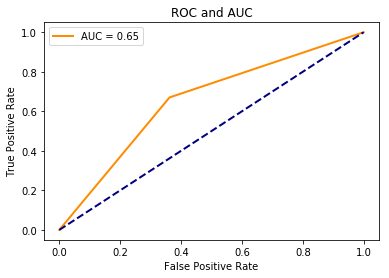

AUC score: 0.654


In [107]:
# model evaluation
from sklearn.metrics import roc_curve, auc    

fpr, tpr, _ = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="best")
plt.show()
print("AUC score: %3.3f" % roc_auc)

In [73]:
columns = (list(X_train))

In [74]:
a = (LR_model.coef_)


In [76]:
# print out column names as columns and coefficients as values
col3= df = pd.DataFrame(a,columns=columns)
col3.head()

,annual_inc,loan_amnt,pub_rec,chargeoff_within_12_mths,int_rate,installment,dti,inq_last_6mths,acc_open_past_24mths,mort_acc,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,-0.033632,-0.102089,0.029025,0.006806,0.104883,0.203633,0.150677,0.031261,0.133699,-0.110642,...,0.024862,-0.004994,0.011809,0.014273,0.010673,0.007861,0.000447,0.046985,0.008261,-0.015177


In [77]:
#export to csv
col3.to_csv('C:/Users/Farhan/Documents/Capstone/coefficients.csv')